# Actividad 16: Análisis de Componentes Principales (PCA)

En esta actividad hice un PCA sobre variables ambientales de la Laguna de Términos para reducir dimensionalidad y visualizar patrones.  
El flujo que seguí fue:
1) Verificar **adecuación** (Bartlett y KMO).  
2) Correr PCA, revisar **eigenvalores** y el **Scree plot**.  
3) Hacer dos biplots: uno sencillo y uno con colores por temporada.




In [1]:
import pandas as pd
import numpy as np

# Cargar datos
CO2Data = pd.read_csv("../data/Terminos_lagoon_TA_DIC_2023_RawData.csv")

# Variables para PCA (ajusta si alguna no existe en tu CSV)
selected_vars = [
    'depth_m', 'do_mg_l', 'sal_psu',
    'turbidity_fnu', 'temp_c',
    'ta_micromol_kg', 'dic_micromol_kg',
    'chlorophy_microg_l'  # comenta esta línea si no existe en tu archivo
]

# Subconjunto y descarte de faltantes (solo en estas columnas)
X = CO2Data[selected_vars].dropna()
X.head()


,depth_m,do_mg_l,sal_psu,turbidity_fnu,temp_c,ta_micromol_kg,dic_micromol_kg,chlorophy_microg_l
0,0.464,7.12,3.56,1.47,28.740,3863,3915,0.36
1,7.792,4.90,16.97,95.33,29.028,3685,3698,4.19
2,0.453,6.99,8.94,5.50,29.283,3708,3724,0.92
3,1.261,6.52,13.87,13.44,29.024,3992,3667,2.23
4,0.465,6.24,28.06,3.60,28.202,3023,2928,0.58


In [2]:
import pandas as pd
import numpy as np

# Cargar datos
CO2Data = pd.read_csv("../data/Terminos_lagoon_TA_DIC_2023_RawData.csv")

# Variables para PCA (ajusta si alguna no existe en tu CSV)
selected_vars = [
    'depth_m', 'do_mg_l', 'sal_psu',
    'turbidity_fnu', 'temp_c',
    'ta_micromol_kg', 'dic_micromol_kg',
    'chlorophy_microg_l'  # comenta esta línea si no existe en tu archivo
]

# Subconjunto y descarte de faltantes (solo en estas columnas)
X = CO2Data[selected_vars].dropna()
X.head()


,depth_m,do_mg_l,sal_psu,turbidity_fnu,temp_c,ta_micromol_kg,dic_micromol_kg,chlorophy_microg_l
0,0.464,7.12,3.56,1.47,28.740,3863,3915,0.36
1,7.792,4.90,16.97,95.33,29.028,3685,3698,4.19
2,0.453,6.99,8.94,5.50,29.283,3708,3724,0.92
3,1.261,6.52,13.87,13.44,29.024,3992,3667,2.23
4,0.465,6.24,28.06,3.60,28.202,3023,2928,0.58


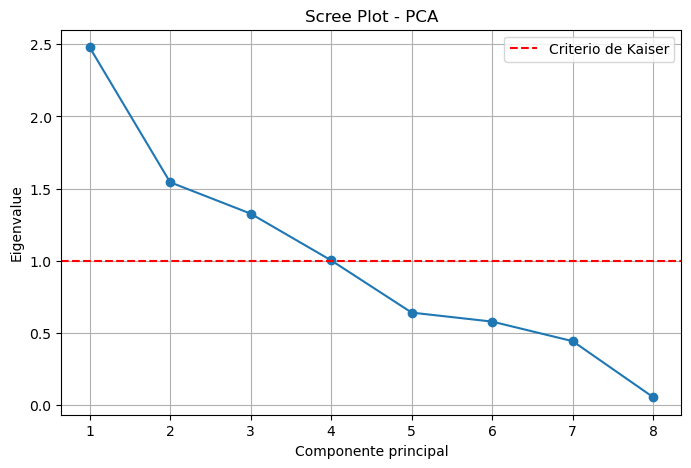

Varianza explicada (primeros 5 PCs): [0.307 0.191 0.164 0.124 0.079]


In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarizar (clave para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# PCA con todos los componentes (para ver eigenvalores)
pca = PCA()
principal_components = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Criterio de Kaiser')
plt.title('Scree Plot - PCA')
plt.xlabel('Componente principal')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

print("Varianza explicada (primeros 5 PCs):", np.round(explained_variance[:5], 3))


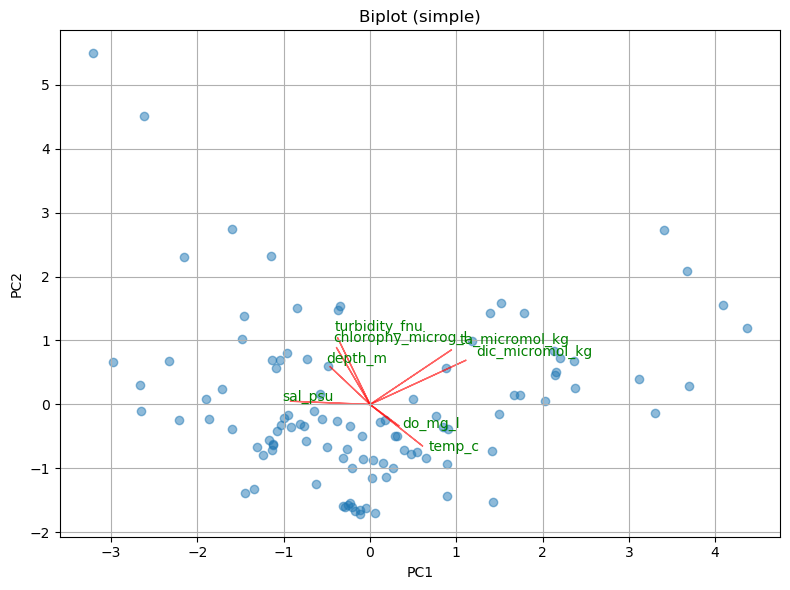

In [4]:
import matplotlib.pyplot as plt

def biplot(scores: np.ndarray, coeff: np.ndarray, labels=None) -> None:
    """
    Biplot sencillo con PC1 vs PC2 y flechas de variables.
    - scores: matriz (n_muestras, n_componentes)
    - coeff: matriz de cargas (n_variables, n_componentes) = pca.components_.T
    """
    xs = scores[:, 0]
    ys = scores[:, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, alpha=0.5)

    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i, 0]*2, coeff[i, 1]*2, color='r', alpha=0.6, length_includes_head=True)
        txt = labels[i] if labels is not None else f"Var{i+1}"
        plt.text(coeff[i, 0]*2.2, coeff[i, 1]*2.2, txt, color='g', fontsize=10)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot (simple)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usar los dos primeros PCs y las cargas asociadas
biplot(principal_components, pca.components_.T, labels=selected_vars)


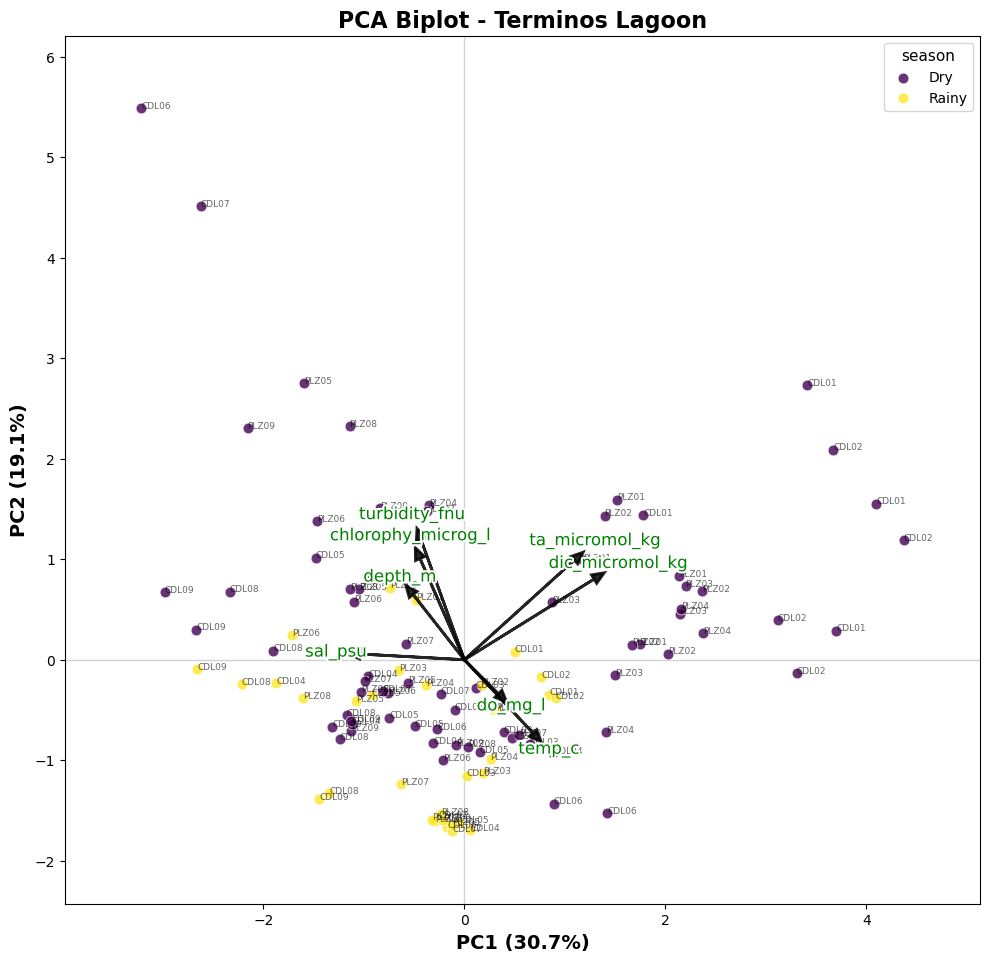

In [5]:
from matplotlib import colormaps
from matplotlib.patheffects import withStroke

def plot_pca_biplot(
    df: pd.DataFrame,
    variables: list,
    group_col: str | None = None,
    label_col: str | None = None,
    scale_arrows: float = 2.5,
    figsize: tuple = (10, 10),
    title: str = "PCA Biplot",
    save_path: str | None = None,
) -> None:
    # Filtrar filas completas en variables + (grupo/etiqueta si se piden)
    cols_to_use = variables + [c for c in [group_col, label_col] if c]
    df_filtered = df.dropna(subset=cols_to_use).copy()
    if df_filtered.empty:
        print("No hay filas completas para graficar.")
        return

    # Estandarizar y PCA (2 componentes)
    X2 = df_filtered[variables].values
    X2_scaled = StandardScaler().fit_transform(X2)
    pca2 = PCA(n_components=2)
    scores = pca2.fit_transform(X2_scaled)
    loadings = pca2.components_.T  # (n_vars, 2)

    groups = df_filtered[group_col] if group_col else None
    labels = df_filtered[label_col] if label_col else None
    unique_groups = sorted(groups.unique()) if groups is not None else [None]

    colors = {}
    if groups is not None and len(unique_groups) > 0:
        cmap = colormaps.get_cmap('viridis').resampled(len(unique_groups))
        colors = {g: cmap(i) for i, g in enumerate(unique_groups)}
    else:
        default_color = 'blue'

    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(0, color='lightgray', lw=1, zorder=1)
    ax.axvline(0, color='lightgray', lw=1, zorder=1)

    # Puntos
    if groups is not None:
        for g in unique_groups:
            idx = (groups == g).values
            ax.scatter(scores[idx, 0], scores[idx, 1],
                       s=60, alpha=0.8, edgecolor='white', linewidth=0.6,
                       color=colors[g], label=str(g), zorder=2)
        ax.legend(title=group_col, fontsize=10, title_fontsize=11)
    else:
        ax.scatter(scores[:, 0], scores[:, 1],
                   s=60, alpha=0.8, edgecolor='white', linewidth=0.6,
                   color=default_color, zorder=2)

    # Etiquetas de puntos (si se pide)
    if labels is not None:
        for i, txt in enumerate(labels):
            ax.text(scores[i, 0], scores[i, 1], str(txt),
                    fontsize=6.5, alpha=0.6, zorder=3)

    # Flechas de variables
    for i, var in enumerate(variables):
        ax.arrow(0, 0, loadings[i, 0]*scale_arrows, loadings[i, 1]*scale_arrows,
                 color='black', linewidth=2.0, alpha=0.85,
                 head_width=0.10, head_length=0.12, length_includes_head=True, zorder=4)
        ax.text(loadings[i, 0]*scale_arrows*1.1, loadings[i, 1]*scale_arrows*1.1, var,
                fontsize=12, color='green',
                ha='center', va='center',
                path_effects=[withStroke(linewidth=3, foreground='white')], zorder=5)

    ax.set_xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]:.1%})', fontsize=14, weight='bold')
    ax.set_ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]:.1%})', fontsize=14, weight='bold')
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_aspect('equal')

    # Márgenes cómodos
    m = 0.1
    xmin, xmax = scores[:, 0].min(), scores[:, 0].max()
    ymin, ymax = scores[:, 1].min(), scores[:, 1].max()
    ax.set_xlim(xmin - (xmax - xmin)*m, xmax + (xmax - xmin)*m)
    ax.set_ylim(ymin - (ymax - ymin)*m, ymax + (ymax - ymin)*m)

    plt.tight_layout()

    if save_path:
        is_raster = save_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff'))
        dpi = 600 if is_raster else None
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

# Nota: en este dataset no hay 'sample'; uso 'station' para etiquetas.
plot_pca_biplot(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='station',  # si no quieres etiquetas, usa None
    title='PCA Biplot - Terminos Lagoon',
    save_path='../output_files/pca_biplot_terminos_lagoon.pdf',
)
